# Boolean Pandemic 
## Final Project for Machine Learning

This project contains the following sections:

1. Data understanding (missing some comments and explanations)
2. Data preprocessing (missing an explanation for hot encoding dummy variables)
3. Feature engineering (pretty much done)
4. Methodology (Radu)
5. Model evaluation and comparison (missing the rest of the models)
    1. Support Vector Machine
        1. Feature Selection
        2. Model Tunning
    2. K Nearest Neighbors
6. Final Result (missing everything)

## 1. Data Understanding

In the following section we will explore the data by looking at descriptive statistics and visualizations, in order to understand our features' distribution, identify outliers, and reveal any data issues (e.g. missing values) that might exist.

In [1]:
import pandas as pd
from plots import *
from dataset import Dataset

%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

dataset = Dataset()
df = dataset.train_data
print(f"Dataset rows: {df.shape[0]}")
print(f"Dataset columns ({df.shape[1]}):")
for column in list(df.columns):
    print("  - " + column)

Dataset rows: 900
Dataset columns (10):
  - Family_Case_ID
  - Severity
  - Name
  - Birthday_year
  - Parents or siblings infected
  - Wife/Husband or children infected
  - Medical_Expenses_Family
  - Medical_Tent
  - City
  - Deceased


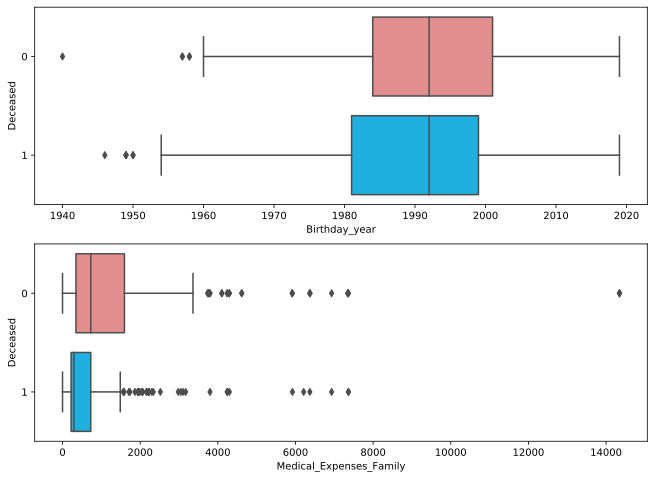

In [2]:
box_plots(df)

In [3]:
df.isna().sum()

Family_Case_ID                         0
Severity                               0
Name                                   0
Birthday_year                        177
Parents or siblings infected           0
Wife/Husband or children infected      0
Medical_Expenses_Family                0
Medical_Tent                         702
City                                   2
Deceased                               0
dtype: int64

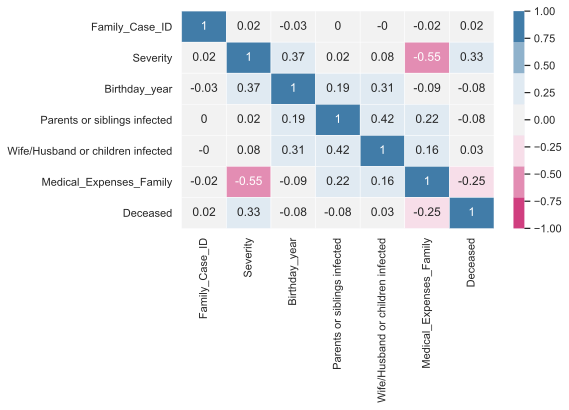

In [4]:
pearson_correlation_plot(df)

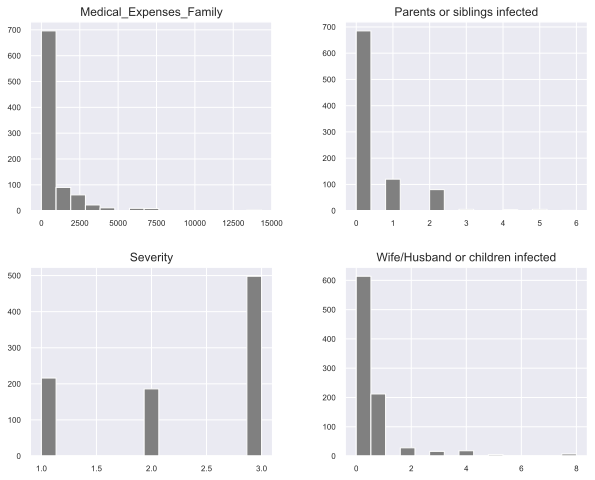

In [5]:
plot_numerical_variables(df)

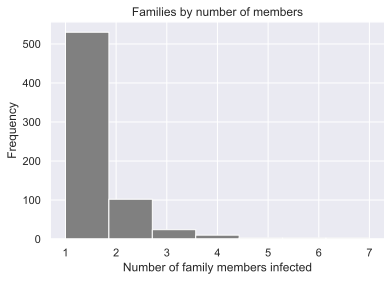

In [6]:
family_sizes(df)

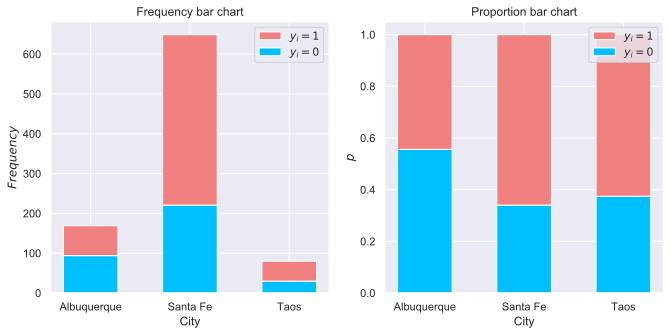

In [7]:
bar_charts_categorical(df, 'City', 'Deceased')

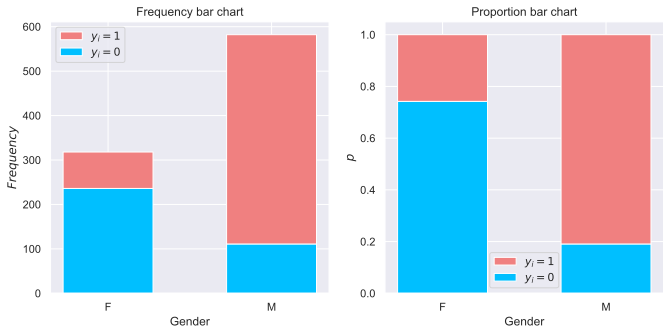

In [8]:
dataset.create_gender()
bar_charts_categorical(df, 'Gender','Deceased')

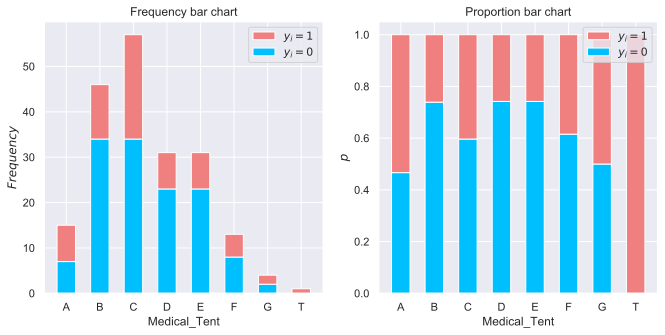

In [9]:
bar_charts_categorical(df, 'Medical_Tent','Deceased')

## 2. Data Preparation

In the following section we will apply some basic transformations to the data.

### 2.1 Deal with empty values

Birthday year and medical tent are the columns with most empty values. To deal with this we decided to just label them as "Empty", for the Tent we set them as N/A, for birthday year as -1.

City has two missing values only, so we can drop them.

In [10]:
df['Medical_Tent'] = df['Medical_Tent'].replace(np.nan, 'n/a', regex=True)
df['Birthday_year'] = df['Birthday_year'].replace(np.nan, -1, regex=True)
df = df[df['City'].notna()]

### 2.2 Convert categorical variables to numeric


In [11]:
## Name is no longer needed
del df['Name']

df_with_categories = pd.get_dummies(df, prefix=['Medical_Tent', 'City', 'Gender'])
for column in list(df.columns):
    print("  - " + column)

  - Family_Case_ID
  - Severity
  - Birthday_year
  - Parents or siblings infected
  - Wife/Husband or children infected
  - Medical_Expenses_Family
  - Medical_Tent
  - City
  - Deceased
  - Gender


## 3. Feature Engineering

### 3.1 Severity by City

Average severity in the city of the patient.

In [12]:
mean = df[["Severity",'City']].groupby(['City']).mean()
mean["Sev_by_city"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_city"], on='City', how='left')

### 3.2 Severity by Tent

Average severity in the medical tent of the patient.

In [13]:
mean = df[["Severity",'Medical_Tent']].groupby(['Medical_Tent']).mean()
mean["Sev_by_tent"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_tent"], on='Medical_Tent', how='left')

### 3.3 Severity by Gender

Average severity whithin the gender of the patient.

In [14]:
mean = df[["Severity",'Gender']].groupby(['Gender']).mean()
mean["Sev_by_gender"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_by_gender"], on='Gender', how='left')

### 3.4 Severity of Family

Average severity in the family of the patient.

In [15]:
mean = df[["Severity",'Family_Case_ID']].groupby(['Family_Case_ID']).mean()
mean["Sev_family"] = mean["Severity"]
del mean["Severity"]
df = df.join(mean["Sev_family"], on='Family_Case_ID', how='left')

### 3.5 Family Size

Number of patients of a single family in the database.

In [16]:
df["family_size"] = [df.Family_Case_ID.value_counts()[fid] for fid in df.Family_Case_ID.values]

### 3.6 Spending vs. Severity

Medical Expenses Family and Patient's Severity ratio.

In [17]:
df["spending_vs_severity"] = df["Medical_Expenses_Family"] / df["Severity"]

### 3.7 Spending per Family Member

Medical Expenses Family divided by the number of cases in the family.

In [18]:
df["spending_family_member"] = df["Medical_Expenses_Family"] / df["family_size"]

### 3.8 Severity vs. City Average

Patient's severity divided by the city average.

In [19]:
df["severity_against_avg_city"] = df["Severity"] / df["Sev_by_city"]

### 3.9 Severity vs. Gender Average

Patient's severity divided by its gender average.

In [20]:
df["severity_against_avg_gender"] = df["Severity"] / df["Sev_by_gender"]

### 3.10 Severity vs. Tent's Average

Patient's severity divided the average in its tent.

In [21]:
df["severity_against_avg_tent"] = df["Severity"] / df["Sev_by_tent"]

### 3.11 Spending per Member vs. Severity

Spending of a family per member (section 3.6) divided by patient's severity. 

In [22]:
df["spending_family_severity"] = df["spending_family_member"] / df["Severity"]

## 4. Methodology

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

## 5. Model Comparison

### 5.1 First model - Support Vector Machine

In [23]:
dataset = Dataset()            # Loads the preprocessed dataset
dataset.apply_preparation()    # Applies preprocessing and feature engineering
train_set = dataset.train_data # Training set without labels (train.csv)
target = dataset.target        # Labels for training set     (train.csv[Deceased])
test_set = dataset.test_data   # Unlabeled test set          (test.csv)

#### 5.1.1 Feature Selection and Transformation

By using boxplots, we selected the variables that had more difference when comparing between deceased and alive patients. These boxplots can be found in the object ```model```.

To run boxplots:
```
from model import Model

model = Model()
model.draw_boxplots()
```

To have an equal weight in each of the variables, we apply an standard scaler for our dataset.

In [24]:
from sklearn.preprocessing import StandardScaler

selected_variables_SVC = [
    'Severity',
    'Gender_M',
    'City_Albuquerque',
    'City_Santa Fe',
    "severity_against_avg_gender",
    'Medical_Tent_n/a',
    'spending_family_member',
    'family_size',
    'Sev_family'
]

scaler = StandardScaler().fit(test_set[selected_variables_SVC])
train_set[selected_variables_SVC] = scaler.transform(train_set[selected_variables_SVC])
test_set[selected_variables_SVC] = scaler.transform(test_set[selected_variables_SVC])

#### 5.1.2 Model and Results

The class model does the following:

1. Creates and prepares the dataset if no dataset is provided as parameter.
2. Selects a subset of variables to be used for training the model.
3. Splits the dataset into 5-folds for cross validation.
4. Trains five models using the five splits.
5. Keeps the best performing model for prediction.

Using the model provided in the parameters from SKLearn.

In [29]:
from sklearn import svm
from model import Model

# Create classifier from SciKitLearn
svm_model = svm.NuSVC()

model = Model(model     = svm_model,              # Initialized classifier model from SKLearn
              variables = selected_variables_SVC, # Subset of variables from data to be used for training
                                                  # If variables=None, then all variables in set are used
              
              train_set = train_set,              # Samples X for training and validating
              target    = target,                 # Samples Y for training and validating
              test_set  = test_set                # Unlabeled samples for creating prediction
              )                 

model.run_model(path="results/svc_results.csv")

Model - NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)
Average model accuracy: 80.73%
Highest model accuracy: 86.11%
Solution set saved as 'results/svc_results.csv'.


### 5.2 Second model - K Nearest Neighbors

In [32]:
from sklearn import neighbors
knn_model = neighbors.KNeighborsClassifier(n_neighbors = 5, 
                               weights = 'uniform', 
                               algorithm = 'auto', 
                               leaf_size = 30, 
                               p = 2, 
                               metric='minkowski'
                              )

model_2 = Model(model = knn_model)
model_2.run_model(path="results/knn_results.csv")

Model - KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
Average model accuracy: 78.51%
Highest model accuracy: 82.22%
Solution set saved as 'results/knn_results.csv'.
